In [94]:
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [95]:
tf.debugging.set_log_device_placement(True)

tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# 심층 신경망 훈련하기 - DNN

* 까다로운 그레디언트 소실 또는 폭주 문제에 직면하는 경우. 
  
  심층 신경망의 아래쪽으로 갈수록 그레디언트가 점점 더 작아지거나 커지는 현상.

* 대규모 신경망을 위한 훈련데이터가 충분치 않거나 레이블을 만드는 작업에 비용이 너무 많이 들 때.

* 수백만 개의 파라미터를 가진 모델은 훈련세트에 과대적합될 위험이 매우 큼. 
  
  특히 훈련샘플이 충분치 않거나 잡음이 많은 경우.

|

이번장에선 위의 문제들을 해결하고 전이 학습과 비지도 사전훈련을 알아보고, 대규모 모델의 최적화를

알아볼 예정. 대규모 신경망 규제 기법 중 몇가지를 살펴볼 예정. -> 드디어 딥러닝에 도착.

## 그레디언트 소실과 폭주 문제

* 그래디언트 소실(Vanishing Gradient): 알고리즘이 하위층으로 진행될수록 그래디언트가 점점 작아지는 경우

* 그래디언트 폭주(Exploding Gradient): 그래디언트가 점점 커져서 여러 층이 비정상적으로 큰 가중치를 갱신되어 알고리즘이 발산하는 경우

* 로지스틱 활성화 함수의 경우 입력이 커지면 0이나 1로 수렴해서 기울기가 0에 가까워짐

* 역전파가 될 때 사실상 신경망으로 전파할 그래디언트가 거의 없고 조금 있는 그래디언트는 최상위층에서부터 역전파가 진행되면서 점차 약해져서 실제로 아래쪽 층에는 아무것도 도달하지 않는다.

In [96]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: [11-1] sigmoid_saturation_plot


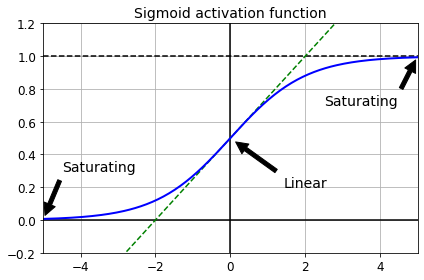

In [97]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("[11-1] sigmoid_saturation_plot")
plt.show()

### 글로럿과 He 초기화

* 글로럿과 벤지오가 불안정한 그래디언트 문제를 완화하는 방법 제안
* 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다고 주장
* 역방향에서 층을 통과하기 전과 후의 그래디언트 분산이 동일
* $fan_{avg}=(fan_{in}+fan_{out})$ 층의 입력 개수는 팬인 출력개수는 팬아웃

|

**식 11-1 글로럿 초기화(로지스틱 활성화 함수를 쓸 때)**

$
\text{평균이 0이고 분산이} \sigma^2=\dfrac{1}{fan_{avg}} \text{인 정규분포}
$
$
\text{또는} r =\sqrt{\dfrac{3}{fan_{avg}}}\text{일 때} -r\text{과} +r \text{사이의 균등분포}
$

|

[식 11-1에서] $fan_{avg}$를 fan_{in}으로 바꾸면 르쿤 초기화가 됨.

글로럿 초기화를 하면 훈련 속도가 증가

---

초기화 전략	| 활성화 함수 | $\sigma^2$(정규분포)

글로럿      | 활성화 함수 없음, tanh, logstic, softmax | $\dfrac{1}{fan_{avg}}$

He         | ReLU 함수와 그 변종들 | $\dfrac{2}{fan_{in}}$

르쿤        | SELU | $\dfrac{1}{fan_{in}}$

---

케라스는 기본적으로 균등 분포의 글로럿 초기화를 사용

다음과 같이 층을 만들 때 kernel_initializer="he_normal"이나 kernel_initializer="he_uniform"로

바꾸어 He 초기화를 사용할 수 있음.

In [98]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

$fan_{in}$대신 $fan_{avg}$기반의 균등분포 He 초기화를 사용하고 싶다면 

다음과 같이 VarianceScaling 사용할 수 있음.

In [99]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

### 수렴하지 않는 활성화 함수

활성화 함수를 잘못 선택하면 자칫 그레디언트의 소실이나 폭주로 이어질 수 있음.

특히 ReLU 함수는 특정 양숫값에 수렴하지 않는다는 큰 장점이 있음(계산도 빠름).

안타깝게도 ReLU 함수가 완벽하지 않아 죽은 ReLU 로 알려진 문제가 있음.

---

-> 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는다는 의미에서 죽었다고 함.

ex) 특히 큰 학습률을 사용하면 신경망의 뉴런 절반이 죽어있기도 함. 

뉴런의 가중치가 바뀌어 훈련세트에 있는 모든 샘플에 대해 입력의 가중치 합이 음수가 되면 뉴런이 죽음.

가중치 합이 음수면 ReLU함수의 그레디언트가 0이 되므로 경사하강법이 더는 작동 X

---

### LeakyReLU

ReLU의 뉴런이 죽는 현상을 해결하기 위해 나온 함수

$
LeakyReLU_\alpha(x)=max(ax, x)$

* 하이퍼파라미터 $\alpha$가 이 함수가 새는(leaky) 정도를 결정한다. 새는 정도란 $x<0$
  일 때 이 함수의 기울기이며, 일반적으로 0.01로 설정

* Bing Xu et al., “Empirical Evaluation of Rectified Activations in Convolutional Network” 
  논문에 따르면 LeakyReLU가 ReLU보다 항상 성능이 높은 것으로 나온다.

* $\alpha=$ 0.2로 하는 것이 0.01보다 더 나은 성능을 내는 것으로 보임.

In [100]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: [11-2] leaky_relu_plot


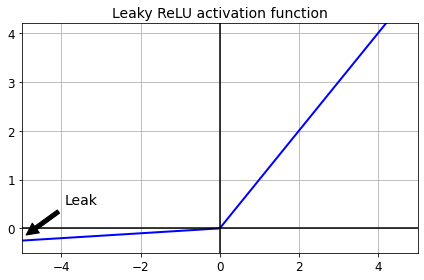

In [101]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("[11-2] leaky_relu_plot")
plt.show()

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련해 보죠:

In [102]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [103]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [104]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [105]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accuracy

#### RReLU (Randomized leaky ReLU)
* $\alpha=$ 를 무작위로 선택하고 테스트 시에는 평균을 사용하는 방법
* 훈련 세트의 과대적함 위험을 줄이는 규제의 역할을 하는 것처럼 보임

#### PReLU (Parametric leaky ReLU)
* $\alpha=$ 가 훈련하는 동안 학습되는 방법.(즉, 하이퍼파라미터가 아니고 다른 모델 파라미터와 
  마찬가지로 역전파에 의해 변경)
* 대규모 이미지 데이터셋에서는 ReLU보다 성능이 크게 앞섰지만, 소규모 데이터셋에서는 훈련 세트에 
  과대적합될 위험이 있다.

PReLU를 테스트해 보죠:

In [106]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [107]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [108]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8178
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_ac

#### ELU (Exponential Linear Unit)

* 다른 모든 ReLU 변종의 성능을 앞지렀다.
* 훈련 시간이 줄고 신경망의 테스트 세트 성능도 더 높았다.

 

**Equation 11-2: ELU activation function**

$\operatorname{ELU}_\alpha (z) =\begin{cases}
\alpha(\exp(z) - 1) & \text{if } z < 0\\
z & if z \ge 0
\end{cases}
$

In [109]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: [11-3] elu_plot


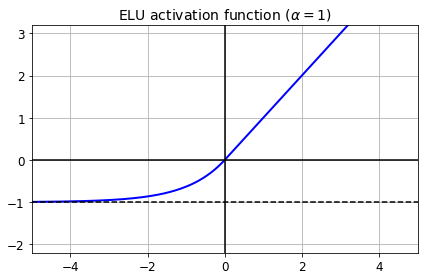

In [110]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("[11-3] elu_plot")
plt.show()

* x<0일 때 음숫값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가깝다. 이는 그래디언트 소실 문제를 완화. 하이퍼파라미터 α는 x가 큰 음숫값일 때 ELU가 수렴할 값을 정의

* x<0이어도 그래디언트가 0이 아니므로 죽은 뉴런을 만들지 않는다.

* α=1이면 이 함수는 x=0에서 급격히 변동하지 않으므로 x=0을 포함해 모든 구간에서 매끄러워 경사 하강법의 속도를 높여준다

* 단점: ReLU나 그 변종들보다 계산이 느리다.(훈련하는 동안에는 수렴 속도가 빨라서 느린 계산이 상쇄되지만 테스트 시에는 느릴 것)

#### SELU

* ELU 활성화 함수의 변종
* 완전 연결 층만 쌓아서 신경망을 만들고 모든 은닉층이 SELU 활성화 함수를 사용하면 네트워크가 자기 정규화(self-normalized) 된다고 저자는 주장
* 훈련하는 동안 각 층의 출력이 평균 0과 표준편차 1을 유지하는 경향(그래디언트 소실과 폭주 문제를 막아준다.)
* 다른 활성화 함수보다 뛰어난 성능을 종종 보이지만 자기 정규화가 일어나기 위한 몇가지 조건이 존재

Günter Klambauer, Thomas Unterthiner, Andreas Mayr는 2017년 한 [훌륭한 논문](https://arxiv.org/pdf/1706.02515.pdf)에서 SELU 활성화 함수를 소개했습니다. 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화됩니다. 각 층의 출력이 평균과
표준편차를 보존하는 경향이 있습니다. 이는 그레이디언트 소실과 폭주 문제를 막아줍니다. 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 냅니다. 따라서 꼭 시도해 봐야 합니다. 하지만 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨집니다. ℓ<sub>1</sub>나 ℓ<sub>2</sub> 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없습니다(즉 순환 신경망은 자기 정규화되지 않습니다). 하지만 실전에서 시퀀셜 CNN과 잘 동작합니다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것입니다.

In [111]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [112]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


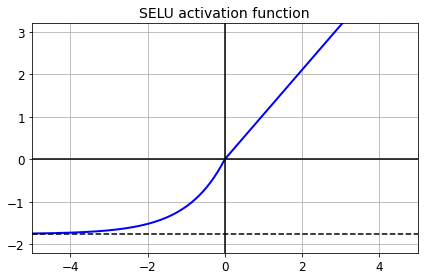

In [113]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

1) 입력 특성이 반드시 표준화(평균 0, 표준편차 1)되어야 한다.

2) 모든 은닉층의 가중치는 르쿤 정규분포 초기화로 초기화되어야 한다. 케라스에서는 kernel_initializer=’lecun_normal’로 설정

3) 네트워크는 일렬로 쌓은 층으로 구성되어야 한다. 순환 신경망이나 스킵 연결과 같은 순차적이지 않은 구조에서 사용하면 자기 정규화되는 것을 보장하지 않는다.

쉽게 SELU를 사용할 수 있습니다:

In [114]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [115]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [116]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [117]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [119]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 83s 48ms/step - loss: 0.5354 - accuracy: 0.8102 - val_loss: 0.4973 - val_accuracy: 0.8254
Epoch 2/5
1719/1719 [==============================] - 86s 50ms/step - loss: 0.4897 - accuracy: 0.8288 - val_loss: 0.4654 - val_accuracy: 0.8410
Epoch 3/5
1719/1719 [==============================] - 88s 51ms/step - loss: 0.4765 - accuracy: 0.8324 - val_loss: 0.4615 - val_accuracy: 0.8402
Epoch 4/5
1719/1719 [==============================] - 84s 49ms/step - loss: 0.4349 - accuracy: 0.8474 - val_loss: 0.4414 - val_accuracy: 0.8448
Epoch 5/5
1719/1719 [==============================] - 86s 50ms/step - loss: 0.4140 - accuracy: 0.8554 - val_loss: 0.4283 - val_accuracy: 0.8580


좋지 않군요. 그레이디언트 폭주나 소실 문제가 발생한 것입니다.

* 일반적으로 SELU > ELU > LeakyReLU(그리고 변종들) > ReLU > tanh > sigmoid 순
* 네트워크가 자기 정규화되지 못하는 구조라면 SELU 보단 ELU
* 실행 속도가 중요하다면 LeakyReLU(하이퍼파라미터를 더 추가하고 싶지 않다면 케라스에서 사용하는 기본값 
$\alpha$ 사용)
* 시간과 컴퓨팅 파워가 충분하다면 교차 검증을 사용해 여러 활성화 함수를 평가
* 신경망이 과대적합되었다면 RReLU
* 훈련세트가 아주 크다면 PReLU
* ReLU가 가장 널리 사용되는 활성화 함수이므로 많은 라이브러리와 하드웨어 가속기들이 ReLU에 특화되어 최적화. 따라서 속도가 중요하다면 ReLU가 가장 좋은 선택

### 배치 정규화 (BN)

* 훈련하는 동안의 그래디언트 소실이나 폭주문제를 해결하기 위한 방법
* 세르게이 이오페, 치리슈티언 세게지가 제안
* 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가
* 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결괏값의 스케일을 조정하고 이동
* 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련세트를 표준화할 필요가 없다.

---

**Equation 11-3: Batch Normalization algorithm**

$\begin{split}
1.\quad & \mathbf{\mu}_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{\mathbf{x}^{(i)}}\\
2.\quad & {\mathbf{\sigma}_B}^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\mathbf{x}^{(i)} - \mathbf{\mu}_B)^2}\\
3.\quad & \hat{\mathbf{x}}^{(i)} = \dfrac{\mathbf{x}^{(i)} - \mathbf{\mu}_B}{\sqrt{{\mathbf{\sigma}_B}^2 + \epsilon}}\\
4.\quad & \mathbf{z}^{(i)} = \gamma \hat{\mathbf{x}}^{(i)} + \beta
\end{split}
$

---

$\mu_B$는 미니배치 B에 대해 평가한 입력의 평균 벡터(입력마다 하나의 평균)

$\sigma_B$도 미니배치에 대해 평가한 입력의 표준편차 벡터

$m_B$는 미니배치에 있는 샘플 수

$\hat{x^{(i)}}$는 평균이 0이고 정규화된 샘플 i의 입력

$\gamma$는 층의 출력 스케일 파라미터 벡터(입력마다 하나의 스케일 파라미터가 존재)

⊗는 원소별 곱셈(각 입력은 해당되는 출력 스케일 파라미터와 곱해진다.)

$\beta$는 층의 출력 이동(오프셋) 파라미터 벡더(입력마다 하나의 스케일 파라미터 존재). 각 입력은 해당 파라미터만큼 이동

$\theta$은 분모가 0이 되는 것을 막기 위한 작은 숫자(전형적으로 $10^{-5}$). 안전을 위한 항(smoothing term) 이라고 함.

* $z^{(i)}$ 는 배치 정규화 연산의 출력. 즉 입력의 스케일을 조정하고 이동시킨 것

* 테스트 시에는 훈련이 끝난 후 전체 훈련 세트를 신경망에 통과시켜 배치 정규화 층의 각 입력에 대한 평균과 표준편차를 계산하여 예측할 때 배치 입력 평균과 표준 편차로 이 ‘최종’ 입력 평균과 표준편차를 대신 사용하는 방법이 있지만 대부분 층의 입력 평균과 표준편차의 이동 평균을 사용해 훈련하는 동안 최종 통계를 추정
* 케라스의 BatchNormalization 층은 이를 자동으로 수행

1. $\gamma$(출력 스케일 벡터)와 $\beta$(출력 이동 벡터)는 일반적인 역전파를 통해 학습

2. $\mu$(최종 입력 평균 벡터)와 $\sigma$(최종 입력 표준편차 벡터)는 지수 이동 평균을 사용하여 추정

3. $\mu$와 $\sigma$는 훈련하는 동안 추정되지만 훈련이 끝난 후에 사용

* 이미지넷 분류 작업에서 큰 성과
* 그래디언트 소실 문제가 크게 감소하여 tanh나 로지스틱 함수와 같은 수렴성을 가진 활성화 함수와도 사용 가능
* 가중치 초기화에 네트워크가 훨씬 덜 민감
* 규제와도 같은 역할을 하여 다른 규제 기법의 필요성 감소
* 단점: 모델의 복잡도가 커짐, 실행 시간 증가(대신 이전 층의 가중치를 바꾸어 이전 층과 배치 정규화 층이 합쳐진 결과를 내어 실행 시간을 단축시킬 수 있음)

**케라스로 배치 정규화 구현하기**

In [120]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [121]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_345 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_346 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)            

여기서 볼 수 있듯이 배치 정규화 층은 입력마다 4개의 파라미터를 추가함.

(ex. 첫번째 배치 정규화 층은 4*784=3136개의 파라미터가 있음)

마지막 2개의 파라미터 $\mu$와 $\sigma$는 이동평균. 이 파라미터는 역전파로 학습되지 않기 때문에

케라스는 'Non-trainable' 파라미터로 분류함(3136+1200+400을 2로 나누면 2368이 나옴.)

In [122]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [123]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [124]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 19s 10ms/step - loss: 0.8750 - accuracy: 0.7124 - val_loss: 0.5525 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.5753 - accuracy: 0.8030 - val_loss: 0.4724 - val_accuracy: 0.8470
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5189 - accuracy: 0.8203 - val_loss: 0.4375 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4827 - accuracy: 0.8323 - val_loss: 0.4152 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4564 - accuracy: 0.8408 - val_loss: 0.3997 - val_accuracy: 0.8640
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4397 - accuracy: 0.8473 - val_loss: 0.3866 - val_accuracy: 0.8702
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4241 - accuracy: 0.8514 - val_loss: 0.3763 -

이따금 활성화 함수전에 BN을 적용해도 잘 동작합니다(여기에는 논란의 여지가 있습니다). 또한 `BatchNormalization` 층 이전의 층은 편향을 위한 항이 필요 없습니다. `BatchNormalization` 층이 이를 무효화하기 때문입니다. 따라서 필요 없는 파라미터이므로 `use_bias=False`를 지정하여 층을 만들 수 있습니다:

In [125]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [126]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [127]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 18s 10ms/step - loss: 1.0317 - accuracy: 0.6756 - val_loss: 0.6767 - val_accuracy: 0.7810
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8182
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8358
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5447 - accuracy: 0.8191 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.5109 - accuracy: 0.8278 - val_loss: 0.4434 - val_accuracy: 0.8536
Epoch 6/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.4898 - accuracy: 0.8337 - val_loss: 0.4263 - val_accuracy: 0.8544
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4712 - accuracy: 0.8397 - val_loss: 0.4130 -

### 그레디언트 클리핑

* 역전파될 때 일정 임곗값을 넘어서지 못하게 그래디언트를 자르는 방법
* 케라스에서 구현하려면 옵티마이저를 만들 때 clipvalue와 clipnorm 매개변수를 지정

모든 케라스 옵티마이저는 `clipnorm`이나 `clipvalue` 매개변수를 지원합니다:

In [128]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [129]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전훈련된 층 재사용 - 전이학습

### 케라스를 사용한 전이 학습

패션 MNIST 훈련 세트를 두 개로 나누어 보죠:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 이렇게 나눕니다. 하지만 이미지 개수는 제한하지 않습니다.

A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 보겠습니다. A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대합니다. 왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문입니다. 하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있습니다(반대로 합성곱 층은 훨씬 많은 정보를 전송합니다. 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문입니다. CNN 장에서 자세히 알아 보겠습니다).

In [130]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [131]:
X_train_A.shape

(43986, 28, 28)

In [132]:
X_train_B.shape

(200, 28, 28)

In [133]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [134]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 10s 6ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3890 - val_accuracy: 0.8677
Epoch 2/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3288 - val_accuracy: 0.8822
Epoch 3/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3170 - accuracy: 0.8894 - val_loss: 0.3013 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9016
Epoch 5/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2835 - accuracy: 0.9021 - val_loss: 0.2775 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.9068
Epoch 7/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2719 - val_accuracy

In [135]:
model_A.save("my_model_A.h5")

model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [136]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [137]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 63ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 33ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 34ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 32ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 31ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 35ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 31ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [138]:
model_B.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 784)               0         
                                                                 
 dense_357 (Dense)           (None, 300)               235500    
                                                                 
 dense_358 (Dense)           (None, 100)               30100     
                                                                 
 dense_359 (Dense)           (None, 50)                5050      
                                                                 
 dense_360 (Dense)           (None, 50)                2550      
                                                                 
 dense_361 (Dense)           (None, 50)                2550      
                                                                 
 dense_362 (Dense)           (None, 1)               

In [139]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

`model_B_on_A`와 `model_A`는 층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트됩니다. 이를 피하려면 `model_A`를 클론한 것을 사용해 `model_B_on_A`를 만들어야 합니다:

In [140]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

이제 작업 B를 위해 model_B_on_A를 훈련할 수 있음. 하지만 새로운 출력층이

랜덤하게 초기화되어 있으므로 큰 오차를 만들 것. 따라서 큰 오차 그레디언트가 재사용된 가중치를

망칠 수 있음. 이를 피하기 위해 처음 몇 번의 에포크 동안은 재사용된 층 동결하고 새로운 층에게

적절한 학습할 시간을 주는 것

In [141]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False     # 재사용된 층 동결을 위해 False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [142]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True      # 재사용된 층의 동결 해제

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 56ms/step - loss: 0.2674 - accuracy: 0.9350 - val_loss: 0.2814 - val_accuracy: 0.9249
Epoch 2/4
7/7 [==============================] - 0s 28ms/step - loss: 0.2576 - accuracy: 0.9400 - val_loss: 0.2716 - val_accuracy: 0.9300
Epoch 3/4
7/7 [==============================] - 0s 29ms/step - loss: 0.2481 - accuracy: 0.9400 - val_loss: 0.2628 - val_accuracy: 0.9331
Epoch 4/4
7/7 [==============================] - 0s 29ms/step - loss: 0.2394 - accuracy: 0.9400 - val_loss: 0.2545 - val_accuracy: 0.9361
Epoch 1/16
7/7 [==============================] - 1s 56ms/step - loss: 0.2140 - accuracy: 0.9450 - val_loss: 0.2057 - val_accuracy: 0.9645
Epoch 2/16
7/7 [==============================] - 0s 32ms/step - loss: 0.1709 - accuracy: 0.9550 - val_loss: 0.1729 - val_accuracy: 0.9716
Epoch 3/16
7/7 [==============================] - 0s 34ms/step - loss: 0.1416 - accuracy: 0.9650 - val_loss: 0.1499 - val_accuracy: 0.9807
Epoch 4/16
7/7 [===============

마지막 점수는 어떤가요?

In [143]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [144]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.0563 - accuracy: 0.9940


[0.05628018453717232, 0.9940000176429749]

오차율이 4.9배나 줄음!

In [146]:
(100 - 97.05) / (100 - 99.40)

4.916666666666718

믿을 만한가? 사실 믿으면 안 됨. 속임수 존재! 왜 속임수를 썼을까?

전이학습은 작은 완전 연결 네트워크에서는 잘 동작하지 않기 때문. 아마 작은 네트워크는 패턴 수를 적게

학습하고 완전 연결 네트워크는 특정 패턴을 학습하기 때문일 것. 

전이학습은 좀 더 일반적인 특성을 감지하는 경향이 있는 심층합성곱 신경망에서 잘 동작. 

(14장에서 다룰 예정)

### 비지도 사전훈련

더 많은 레이블된 훈련데이터를 모이기 어려울 때 사용하는 방법.

레이블되지 않은 훈련데이터를 많이 모을 수 있다면 이를 사용해 

오토인코더나 생성적 적대 신경망(17장 참조)과 같은 비지도 학습 모델을 훈련할 수 있음.

그다음 오토인코더나 GAN 판별자의 하위층을 재사용하고 그 위에 새로운 작업에 맞는 출력층을 추가가능.

그다음 지도 학습으로 (즉, 레이블된 훈련 샘플로) 최종 네트워크를 세밀하게 튜닝.

### 보조 작업에서 사전훈련

레이블된 훈련데이터가 많지 않다면 마지막 선택사항은 레이블된 훈련데이터를 쉽게 얻거나 생성가능한

보조 작업에서 첫번째 신경망을 훈련하는 것. 그리고 이 신경망의 하위층을 실제작업을 위해 재사용.

첫번째 신경망의 하위층은 두번째 신경망에 재사용될 수 있는 특성 추출기를 학습하게 됨.

|

자연어 처리(NLP) 애플리케이션에서는 수백만 개의 텍스트 문서로 이루어진 코퍼스를

다운로드하고 이 데이터에서 레이블된 데이터를 자동으로 생성할 수 있음. 

(15장에서 사전훈련 작업에 대해 더 알아보겠습니다.)

## 고속 옵티마이저

### 모멘텀 최적화

표준적인 경사 하강법은 경사면을 따라 일정한 크기의 스텝으로 조금씩 내려가는 반면 모멘텀 최적화는 처음에는 느리게 출발하지만 종단속도에 도달할 때가지는 빠르게 가속.

**Equation 11-4: Momentum algorithm**

1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\theta J(\theta)$

2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$

* 모멘텀 최적화는 이전 그래디언트가 얼마였는지가 상당히 중요
* 현재 그래디언트를 (학습률 $\eta$를 곱한 후) 모멘텀 벡터 $m$에 더하고 
  이 값을 빼는 방식으로 가중치를 갱신
* 일종의 마찰저항을 표현하고 모멘텀이 너무 커지는 것을 막기 위해 모멘텀이라는 새로운 하이퍼파라미터 
  $\beta$ 사용(일반적인 모멘텀 값은 0.9)더 바르게 평편한 지역을 탈출하게 도움
* 경사 하강법이 가파른 경사를 꽤 빠르게 내려가지만 좁고 긴 골짜기에서는 오랜 시간이 걸린다. 
  모멘텀 최적화는 골짜기를 따라 바닥(최적점)에 도달할 때가지 점점 더 빠르게 내려간다.
* 배치 정규화를 사용하지 않는 심층 신경망에서 상위층은 종종 스케일이 매우 다른 입력을 받게 되는데 
  이런 경우 사용하면 도움이 된다.
* 또한 지역 최적점을 건너뛰도록 하는 데도 도움

In [147]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### 네스테로프 가속 경사

현재 위치가 $\theta$가 아니라 모멘텀 방향으로 조금 앞선 $\theta_\beta m$ 에서 비용 함수의 그래디언트를 계산하는 것

**Equation 11-5: Nesterov Accelerated Gradient algorithm**

1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\theta J(\theta + \beta m)$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$

* 원래 위치에서의 그래디언트를 사용하는 것보다 그 방향으로 조금 더 나아가서 
  측정한 그래디언트를 사용하는 것이 더 정확할 것
* 진동을 감소시키고 수렴을 빠르게 만들어 준다.
* 일반적으로 기본 모멘텀 최적화보다 훈련 속도가 빠르다.

In [148]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### AdaGrad

가장 가파른 차원을 따라 그래디언트 벡터의 스케일을 감소

**Equation 11-6: AdaGrad algorithm**

1. $ \mathbf{s} \gets \mathbf{s} + \nabla_\theta J(\boldsymbol{\theta}) \otimes \nabla_\theta J(\boldsymbol{\theta}) $
2. $ \boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta, \nabla_\theta J(\boldsymbol{\theta}) \oslash {\sqrt{\mathbf{s} + \epsilon}} $

* 첫 번째 단계로 그래디언트 제곱을 벡터 $s$에 누적(각 원소 $s_i$마다 파라미터 $θ_i$ 에 대한 
  비용 함수의 편미분을 제곱하여 누적)
* 두 번째 단계로 그래디언트 벡터를 $\sqrt{s+\epsilon}$ 으로 나누어 스케일을 조정 
  (⊘기호는 원소별 나눗셈을 나타내고 $\epsilon$ 은 0으로 나누는 것을 막기 위한 값으로, 
  일반적으로 $10^{-10}$)
* 이 알고리즘은 학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소하며 
  이를 적응적 학습률(adaptive learning)이라고 부르며, 전역 최적점 방향으로 
  더 곧장 가도록 갱신되는 데 도움
* 학습률 하이퍼파라미터 $\eta$를 덜 튜닝해도 되는 점이 또 하나의 장점

* 간단한 2차 방정식 문제에 대해서는 잘 작동하지만 신경망을 훈련할 때 너무 일직 멈추는 경우가 있음.  
  학습률이 너무 감소되어 전역 최적점에 도착하기전에 알고리즘이 멈춤.
* 케라스에 Adagrad 옵티마이저가 있지만 심층 신경망에 사용하지 말 것

In [149]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

### RMSProp

* 가장 최근 반복에서 비롯된 그래디언트만 누적함으로써 AdaGrad가 
  전역 최적점에 도착하기 전에 알고리즘이 멈추는 문제를 해결
* 지수 감소를 사용

**Equation 11-7: RMSProp algorithm**

1. $\mathbf{s} \gets \beta \mathbf{s} + (1 - \beta ) \nabla_\theta J(\boldsymbol{\theta}) \otimes \nabla_\theta J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta \, \nabla_\theta J(\boldsymbol{\theta}) \oslash {\sqrt{\mathbf{s} + \epsilon}}$

* 보통 감쇠율 $\beta$ 는 0.9로 설정
* 기본값이 잘 작동하는 경우가 많으므로 튜닝할 필요는 전혀 없음

In [150]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

* rho 매겨변수는 $\beta$
* AdaGrad보다 훨씬 더 성능이 좋다.

### Adam과 Nadam 최적화

### Adam

* 적응적 모멘트 추정(adaptive moment estimation)을 의미
* 모멘텀 최적화와 RMSProp의 아이디어를 합친 것
* 모멘텀 최적화처럼 지난 그래디언트의 지수 감소 평균을 따르고 RMSProp처럼 
  지난 그래디언트 제곱의 지수 감소된 평균을 따른다.

**Equation 11-8: Adam algorithm**

1. $\mathbf{m} \gets \beta_1 \mathbf{m} - (1 - \beta_1) \nabla_\theta J(\boldsymbol{\theta})$
2. $\mathbf{s} \gets \beta_2 \mathbf{s} + (1 - \beta_2) \nabla_\theta J(\boldsymbol{\theta}) \otimes \nabla_\theta J(\boldsymbol{\theta})$
3. $\hat{\mathbf{m}} \gets \left(\dfrac{\mathbf{m}}{1 - {\beta_1}^T}\right)$
4. $\hat{\mathbf{s}} \gets \left(\dfrac{\mathbf{s}}{1 - {\beta_2}^T}\right)$
5. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \eta \, \hat{\mathbf{m}} \oslash {\sqrt{\hat{\mathbf{s}} + \epsilon}}$

* t는 (1부터 시작하는) 반복 횟수
* 단계 1,2,5는 모멘텀 최적화, RMSProp과 비슷
* 단계 3,4에서 m,s는 0으로 초기화되기 때문에 훈련 초기에 0쪽으로 치우치게 된다. 
  그래서 이 두 단계가 훈련 초기에 m,s의 값을 증폭시키는 데 도움을 준다.
* 반복 초기에는 m,s를 증폭시켜주지만 반복이 많이 진행되면 단계 3,4의 분모는 1에 가까워져 
  거의 증폭되지 않는다.
* 모멘텀 감쇠 하이퍼파라미터 $\beta_1$은 보통 0.9로, 스케일 감쇠 하이퍼파라미터 $\beta_2$는 0.999로 초기화

In [151]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Adam이 적응적 학습률 알고리즘이기 때문에 학습률 하이퍼파라미터 
$\eta$를 튜닝할 필요가 적다.(기본값 0.001을 일반적으로 사용)

### Adamax

* Adam은 시간에 따라 감쇠된 그래디언트의 $l_2$노름으로 파라미터 업데이트의 스케일을 낮춘다.
  ($l_2$노름은 제곱 합의 제곱근)
* Adamax는 $l_2$노름을 $l_∞$노름으로 바꾼다

**Equation 11-8: AdaMax algorithm**
1. $\mathbf{m} \gets \beta_1 \mathbf{m} - (1 - \beta_1) \nabla_\theta J(\boldsymbol{\theta})$
2. $\mathbf{s} \gets \max(\beta_2 \mathbf{s},\nabla_\theta J(\boldsymbol{\theta}))$
3. $\hat{\mathbf{m}} \gets \left(\dfrac{\mathbf{m}}{1 - {\beta_1}^T}\right)$
4. $\hat{\mathbf{s}} \gets \left(\dfrac{\mathbf{s}}{1 - {\beta_2}^T}\right)$
5. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \eta \, \hat{\mathbf{m}} \oslash {\sqrt{\hat{\mathbf{s}} + \epsilon}}$

In [152]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

* Adamax가 Adam보다 더 안정적
* 하지만 실제로 데이터셋에 따라 다르고 일반적으로 Adam의 성능이 더 낫다.

### Nadam

* Adam 옵티마이저에 네스테로프 기법을 더한 것
* Adam보다 조금 더 빠르게 수렴
* 일반적으로 Nadam이 Adam보다 성능이 좋았지만 이따금 RMSProp이 나을 때도 있다.


In [153]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

모든 최적화 기법은 1차 편미분(야코비얀)에만 의존. 2차 편미분(헤시안)을 기반으로 한 뛰어난 알고리즘들이 있지만 하나의 출력마다 n개의 1차 편미분이 아니라 
$n^2$ 개의 2차 편미분을 계산을해야 하기 때문에 메모리 용량을 넘어서거나 계산이 너무 느려서 심층 신경망에 적용하기 어렵다.

옵티마이저 비교(*=나쁨, *=보통, **=좋음)

클래스	수렴속도	수렴품질
SGD	      *	        ***
Momentum	**	      ***
Nesterov	**	      ***
AdaGrad	  ***	      * (너무 일찍 멈춤)
RMSProp	  ***	      ** 또는 ***
Adam	    ***	      ** 또는 ***
Nadam	    ***	      ** 또는 ***
AdaMax	  ***	      ** 또는 ***

### 학습률 스케줄링

* 학습률을 너무 크게 잡으면 발산할 수 있으며, 너무 작게 잡으면 최적점에 수렴하는데 오랜 시간이 걸린다.

* 큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추면 최적의 고정 학습률 보다 좋은 솔루션을 더 빨리 발견할 수 있다.

* 이를 학습 스케줄이라고 한다

#### 거듭제곱 스케줄링

학습률을 반복 횟수 t에 대한 함수 $\eta(t)=\eta/(1+t/s)^c $
로 지정. 

($\eta_0$: 초기 학습률, $c$: 거듭제곱 수, $s$: 스텝 횟수)

처음에는 빠르게 감소하다가 점점 더 느리게 감소

#### 지수 기반 스케줄링

$\eta(t)=\eta_0 0.16{t/s}$ 로 설정. 학습률이 $s$ 스텝마다 10배씩 감소

#### 구간별 고정 스케줄링

일정 횟수의 에포크 동안 일정한 학습률을 사용하고 그 다음 

또 다른 횟수의 에포크 동안 작은 학습률을 사용하는 방법

#### 성능 기반 스케줄링

매 $N$ 스텝마다 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$ 배 만큼 학습률을 감소

#### 1사이클 스케줄링

1 사이클은 훈련 절반 동안 초기 학습률 $\eta_0$을 선형적으로 $\eta_1$까지 증가. 나머지 절반동안 선형적으로 학습률을 $\eta_0$까지 감소. 마지막 몇 번의 에포크는 학습률을 소수점 몇 째 자리까지 줄인다. 최대 학습률 $\eta_1$은 최적의 학습률을 찾을 때와 같은 방식을 사용해 선택하고 초기 학습률 
$\eta_0$은 대략 10배 정도 낮은 값을 선택

---

**거듭제곱 스케줄링**이 가장 구현하기 쉬움. decay 매개변수만 지정하면 됨.

In [154]:
'''optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4) '''

'optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4) '

**지수 기반 스케줄링과 구간별 스케줄링**도 꽤 간단함.

먼저 현재 에포크를 받아 학습률을 반환하는 함수를 정의해야 함.

In [155]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

$\eta_0$와 $s$를 하드코딩하고 싶지 않다면 이 변수를 설정한 클로저를 반환하는 함수를 만들수 있음.

In [156]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

그다음이 이 스케줄링 함수를 전달해 LearningRateScheduler 콜백을 만듦.

그리고 이 콜백을 fit() 메서드에 전달.

In [157]:
'''lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])'''

'lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)\nhistory = model.fit(X_train_scaled, y_train, epochs=n_epochs,\n                    validation_data=(X_valid_scaled, y_valid),\n                    callbacks=[lr_scheduler])'

만약 에포크마다 스텝이 많다면 스텝마다 학습률을 업데이트하는 것이 좋음.

스케줄 함수는 2번째 매개변수로 현재 학습률을 받을 수 있음.

예를 들어 다음과 같은 스케줄 함수는 이전 학습률에 $0.1^{1/20}$을 곱해 동일한 지수감쇠효과를 냄.

여기서는 에포크가 1이 아닌 0에서부터 감쇠가 시작됨.

In [158]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

이 구현은 (이전 구현과 달리) 옵티마이저의 초기 학습률에만 의존하므로 이를 적절히 설정해야함.

하지만 스케줄 함수가 epoch 매개변수를 사용하면 문제가 좀 복잡해짐.

## 규제를 사용해 과대적합 피하기

10장에서 이미 최상위 규제 방법 중 하나인 조기 종료를 구현함.

또한 배치 정규화는 불안정한 그레디언트 문제를 해결하기 위해 고안되었지만 

꽤 괜찮은 규제방법으로도 사용가능.

### $\ell_1$과 $\ell_2$규제

In [159]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [160]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 17s 9ms/step - loss: 1.5922 - accuracy: 0.8122 - val_loss: 0.7183 - val_accuracy: 0.8328
Epoch 2/2
1719/1719 [==============================] - 15s 9ms/step - loss: 0.7189 - accuracy: 0.8276 - val_loss: 0.6802 - val_accuracy: 0.8382


일반적으로 네트워크의 모든 은닉층에 동일한 활성화함수, 동일한 초기화 전략을 사용하거나

모든 층에 동일한 규제를 적용하기 때문에 동일한 매개변수 값을 반복하는 경우가 많음.

=> 리팩터링 또는 파이썬의 functools.partial()를 사용해 기본 매개변수 값을 사용해 함수 호출 감쌈.

In [161]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 16s 9ms/step - loss: 1.6637 - accuracy: 0.8123 - val_loss: 0.7172 - val_accuracy: 0.8336
Epoch 2/2
1719/1719 [==============================] - 15s 9ms/step - loss: 0.7168 - accuracy: 0.8285 - val_loss: 0.6838 - val_accuracy: 0.8370


### 드롭아웃

매 훈련스텝에서 각 뉴런(입력뉴런은 포함하고 출력뉴런은 제외함)은 

임시적으로 드롭아웃될 확률 $p$를 가짐. 즉, 이번 훈련스텝에는 완전 무시되지만 

다음 스텝에는 활성화될 수 있음. 하이퍼파라미터 $p$를 드롭아웃 비율이라고 하고

보통 10%~50% 사이를 지정. 순환신경망에서는 20~30%에 가깝고 합성곱 신경망에서는 40~50%에 가까움.

훈련이 끝난 후에는 뉴런에 더는 드롭아웃을 적용하지 않음. 이게 전부임 (세부사항은 뒤에 설명)

드롭아웃의 능력을 이해하는 또 다른방법은 각 훈련스텝에서 고유한 네트워크가 생성된다고 생각하는 것.

개개의 뉴런이 있을수도 없을수도 있기 때문에 $2^N$개의 네트워크가 가능함(N은 드롭아웃이 가능한 뉴런수).

이는 아주 큰 값이어서 같은 네트워크가 2번 선택될 가능성이 사실상 거의 없음. 

|

1만번의 훈련스텝을 진행하면 1만개의 다른 신경망을 (각각 하나의 훈련샘플을 사용해) 훈련하게 됨.

이 신경망은 대부분의 가중치를 공유하고 있기 때문에 아주 독립적이지 않음. 하지만 그럼에도 모두 다름.

결과적으로 만들어진 신경망은 이 모든 신경망을 평균한 앙상블로 볼 수 있음.

#### 주의사항

p=50%로 설정되었을때, 특정 뉴런은 평균적으로 두배 많은 입력과 연결되므로, 이런 부분을 보정하기위해, 훈련이 끝난 이후, 연결 가중치에 0.5를 곱함

> 즉, 훈련이 끝난 뒤, 연결 가중치에 보존 확률 (1-p)를 곱한다.

한 가지 사소하나 중요한 기술적 세부사항이 있는데 이를 일반적으로 말하자면

훈련이 끝난 뒤 각 입력의 연결 가중치에 보존확률 (1-$p$)을 곱해야 함. 또는 훈련하는 동안

각 뉴런의 출력을 보존확률로 나눌수도 있음(이 방식이 완전히 같은 것은 아니지만 잘 작동).

|

keras.layers.Dropout 층을 사용해 드롭아웃을 구현함. 이 층은 훈련하는 동안 일부 입력을 랜덤하게 버림.

그다음 남은 입력을 보존확률로 나눔. 훈련이 끝난 후에는 어떤 작업도 하지 않음.

입력을 다음층으로 그냥 전달. 

아래 코드는 드롭아웃 비율 0.2를 사용한 규제를 모든 Dense 층 이전에 적용

In [162]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5716 - accuracy: 0.8030 - val_loss: 0.3666 - val_accuracy: 0.8676
Epoch 2/2
1719/1719 [==============================] - 15s 8ms/step - loss: 0.4215 - accuracy: 0.8455 - val_loss: 0.3499 - val_accuracy: 0.8690


모델이 과대적합되었다면 드롭아웃 비율을 늘릴 수 있음. 반대의 상황이면 비율을 낮춰야 함.

층이 클 때는 드롭아웃 비율을 늘리고 작은 층에는 비율을 줄임.

최신의 신경망구조는 마지막 은닉층 뒤에만 드롭아웃을 사용함.

---

### 알파 드롭아웃

In [163]:
tf.random.set_seed(42)
np.random.seed(42)

In [186]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6602 - accuracy: 0.7582 - val_loss: 0.6103 - val_accuracy: 0.8410
Epoch 2/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5559 - accuracy: 0.7946 - val_loss: 0.5654 - val_accuracy: 0.8386
Epoch 3/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5238 - accuracy: 0.8045 - val_loss: 0.5221 - val_accuracy: 0.8482
Epoch 4/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5044 - accuracy: 0.8133 - val_loss: 0.4759 - val_accuracy: 0.8620
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4946 - accuracy: 0.8153 - val_loss: 0.4371 - val_accuracy: 0.8598
Epoch 6/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4823 - accuracy: 0.8228 - val_loss: 0.4679 - val_accuracy: 0.8606
Epoch 7/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4718 - accuracy: 0.8258 - val_loss: 0.4606 - val_ac

In [187]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4434 - accuracy: 0.8601


[0.44340434670448303, 0.8600999712944031]

In [188]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 6s 3ms/step - loss: 0.3277 - accuracy: 0.8821


[0.32773226499557495, 0.8820727467536926]

In [189]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 9s 5ms/step - loss: 0.4215 - accuracy: 0.8428


---

### 몬테 카를로 드롭아웃 (MC 드롭아웃)

In [190]:
tf.random.set_seed(42)
np.random.seed(42)

In [191]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

예측과정에서 일반 dropout기법과 다르게 dropout층을 활성화 시키고, 테스트 셋의 100번 예측 결과를 만듦

모델을 호출할 때마다 샘플이 행이고 클래스마다 하나의 열을 가진 행이 반환.

테스트 세트에 1만개 샘플과 10개의 클래스가 있으므로 이 행렬의 크기는 [10000, 10].

이런 행렬 100개를 쌓았기 때문에 y_probas는 [100, 10000, 100] 크기의 행렬.

첫번째 차원(axis=0)을 기준으로 평균하면 한 번의 예측을 수행했을 때와 같은 

[10000 ,100] 크기의 배열 y_proba를 얻게 됨. 이게 끝!

---

드롭아웃으로 만든 예측을 평균하면 일반적으로 드롭아웃이 없이 

예측한 하나의 결과보다 더 안정적인것 확인 !

예를 들어 드롭아웃을 끄고 패션 MNIST 테스트 세트에 있는 첫번째 샘플의 모델 예측 확인.

In [192]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

모델은 이 이미지가 클래스 9가 맞다고 확신, 정말로 의심의 여지가 없나?

다시 드롭아웃 활성화해 만든 예측과 비교

In [193]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.28, 0.  , 0.01, 0.  , 0.71]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.15, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.02, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.2 , 0.  , 0.79]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.89]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.62, 0.  , 0.26]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.65, 0.  , 0.16, 0.  , 0.19]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.35, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.26, 0.  , 0.5 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.03, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0

드롭아웃 활성화 시 모델이 더 이상 확신하지 않음. 여전히 클래스 9를 선호하나

이따금 클래스 5나 7로 생각. 이들은 모두 신발이니 공통점이 존재함. 첫번째 차원으로 평균을 내면

MC드롭아웃 예측은 다음과 같음.

In [194]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.19, 0.  , 0.67]],
      dtype=float32)

여전히 클래스 9에 속한다고 생각하지만 67%만 확신.

또한 모델이 다른 클래스에 대해 정확히 알 수 있음. 이 확률추정의 표준분포를 확인할 수 있음.

In [195]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.19, 0.  , 0.28]],
      dtype=float32)

이 확률추정에는 많은 분산이 있음. 만약 위험에 민감한 시스템(금융, 의료 등등)을

만든다면 이런 불확실한 예측을 매우 주의 깊게 다뤄야 함.

모델의 정확도도 86.9%로 상승.

In [196]:
y_pred = np.argmax(y_proba, axis=1)

In [197]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.869

모델이 훈련하는 동안 다르게 작동하는 층(BatchNormalization 층과 같은)을 가지고 있다면

앞에서와 같이 훈련모드를 강제로 설정해선 안 됨. 대신 Dropout층을 다음과 같은 MCDropout로 바꿔야 함.

In [198]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

dropout층을 상속하고, call()메서드를 이용해 오버라이드하여 training매개변수를 강제로 True로 설정함.

간단히 말해서 MC드롭아웃은 드롭아웃 모델의 성능을 높여주고, 더 정확한 불확실성 추정을 제공하는 기술.

In [199]:
tf.random.set_seed(42)
np.random.seed(42)

In [200]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [201]:
mc_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout_3 (MCAlpha  (None, 784)              0         
 Dropout)                                                        
                                                                 
 dense_382 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_4 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_383 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_5 (MCAlpha  (None, 100)            

In [202]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [203]:
mc_model.set_weights(model.get_weights())

In [204]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.19, 0.  , 0.63]],
      dtype=float32)

### 맥스-노름 규제

케라스에서 맥스-노름 규제를 구현하려면 다음처럼 적절한 최댓값으로 지정한 max_norm()이

반환한 객체로 은닉층의 kernel_constraint 매개변수를 지정해줌.

In [205]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

매 훈련 반복이 끝난 후 모델의 fit() 메서드가 층의 가중치와 함께 max_norm()이 반환한

객체를 호출하고 스케일이 조정된 가중치를 반환받음. 이 값을 사용해 가중치를 바꿈.

12장에서 보겠지만 필요하면 사용자 정의 규제 함수를 정의함.

In [206]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4752 - accuracy: 0.8331 - val_loss: 0.3684 - val_accuracy: 0.8654
Epoch 2/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3556 - accuracy: 0.8703 - val_loss: 0.3735 - val_accuracy: 0.8664


## 요약 및 실용적인 가이드라인

**기본적인 DNN 설정**

* 커널 초기화 > He 초기화
* 활성화 함수 > ELU
* 정규화 > 얕은 신경일 경우 없음. 깊은 신경망이라면 배치 정규화
* 규제 > 조기종료(필요하다면 $\ell_2$ 규제 추가)
* 옵티마이저 > 모멘텀 최적화(또는 RMSProp이나 Nadam)
* 학습률 스케줄 > 1사이클

**자기정규화를 위한 DNN 설정**

* 커널 초기화 > 르쿤 초기화
* 활성화 함수 > SELU
* 정규화 > 없음 (자기 정규화)
* 규제 > 필요하다면 알파드롭
* 옵티마이저 > 모멘텀 최적화(또는 RMSProp이나 Nadam)
* 학습률 스케줄 > 1사이클

**가이드라인의 몇가지 예외적인 경우 존재**

* 희소모델이 필요하다면 $\ell_1$규제를 사용가능. 매우 희소한 모델이 필요하면 텐서플로 모델 최적화
  툴킷(TF-MOT)을 사용할 수 있음. 이 도구는 자기 정규화를 깨뜨리므로 이 경우 기본 DNN 설정 사용해야함.

* 빠른 응답을 하는 모델(번개처럼 예측하는 모델)이 필요하면 층 개수를 줄이고 배치정규화 층을 이전 층에 
  합치는 것. LeakyReLU나 ReLU와 같이 빠른 활성화 함수 사용. 희소 모델을 만드는 것도 도움됨.
  마지막으로 부동소수점 정밀도를 32비트에서 16비트 혹은 8비트로 낮출수도 있음.
  여기서도 TF-MOT 확인 필요.

* 위험에 민감하고 예측 속도가 매우 중요하지 않은 애플리케이션이라면 성능을 올리고 불확실성 추정과
  신뢰가능한 확률추정을 얻기 위해 MC 드롭아웃을 사용할 수 있음.